In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import transformers
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
import pywt
from scipy.signal import find_peaks
import scipy.io
from datetime import datetime

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# convert str to datatime
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# get capacity data
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]


# get the charge data of a battery
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [ ]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = 'datasets/NASA/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    Battery[name] = getBatteryCapacity(data)

Load Dataset B0005.mat ...
Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [ ]:

def wavelet_denoise(data, wavelet='db4', threshold=0.1):
    #  wavelet decomposition
    coeffs = pywt.wavedec(data, wavelet)

    # threshold for denoising
    coeffs = [pywt.threshold(c, threshold, mode='garrote') for c in coeffs]
    # Reconstruct the denoised signal
    denoised_data = pywt.waverec(coeffs, wavelet)

    return denoised_data


def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)


def split_dataset(data_sequence, train_ratio=0.0, capacity_threshold=0.0):
    if capacity_threshold > 0:
        max_capacity = max(data_sequence)
        capacity = max_capacity * capacity_threshold
        point = [i for i in range(len(data_sequence)) if data_sequence[i] < capacity]
    else:
        point = int(train_ratio + 1)
        if 0 < train_ratio <= 1:
            point = int(len(data_sequence) * train_ratio)
    train_data, test_data = data_sequence[:point], data_sequence[point:]
    return train_data, test_data


def get_train_test(data_dict, name, window_size=8, wavelet='db4', threshold=0.1):
    data_sequence = data_dict[name][1]
    data_sequence = wavelet_denoise(data_sequence, wavelet, threshold)

    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)

    for k, v in data_dict.items():
        if k != name:
            data_sequence = wavelet_denoise(v[1], wavelet, threshold)
            data_x, data_y = build_sequences(text=data_sequence, window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    mae = mean_absolute_error(y_test,y_predict)
    return rmse , mae


def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_dim=8, noise_level=0.01):
        super(Autoencoder, self).__init__()
        self.input_size, self.hidden_dim, self.noise_level = input_size, hidden_dim, noise_level
        self.fc1 = nn.Linear(self.input_size, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.input_size)

    def encoder(self, x):
        x = self.fc1(x)
        h1 = F.relu(x)
        return h1

    def mask(self, x):
        corrupted_x = x + self.noise_level * torch.randn_like(x)
        return corrupted_x

    def decoder(self, x):
        h2 = self.fc2(x)
        return h2

    def forward(self, x):
        out = self.mask(x)
        encode = self.encoder(out)
        decode = self.decoder(encode)
        return encode, decode


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.0, max_len=16):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].squeeze(1)
        return x


class Net(nn.Module):
    def __init__(self, feature_size=16, hidden_dim=32, num_layers=1, nhead=8, dropout=0.0, noise_level=0.01, wavelet='db4', threshold=0.1):
        super(Net, self).__init__()
        self.auto_hidden = int(feature_size/2)
        input_size = self.auto_hidden
        self.pos = PositionalEncoding(d_model=input_size, max_len=input_size)
        encoder_layers = nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout)
        self.cell = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.linear = nn.Linear(input_size, 1)
        self.autoencoder = Autoencoder(input_size=feature_size, hidden_dim=self.auto_hidden, noise_level=noise_level)
        self.wavelet = wavelet
        self.threshold = threshold

    def forward(self, x):
        batch_size, feature_num, feature_size = x.shape

        x = x.cpu().numpy()


        denoised_x = [torch.from_numpy(wavelet_denoise(x[i, 0, :], self.wavelet, self.threshold)).to(device) for i in range(batch_size)]


        denoised_x = torch.stack(denoised_x)


        denoised_x = denoised_x.view(batch_size, feature_num, feature_size)
        encode, decode = self.autoencoder(denoised_x.reshape(batch_size, -1))

        out = encode.reshape(batch_size, -1, self.auto_hidden)
        out = self.pos(out)
        out = out.reshape(1, batch_size, -1)  # (1, batch_size, feature_size)
        out = self.cell(out)
        out = out.reshape(batch_size, -1)  # (batch_size, hidden_dim)
        out = self.linear(out)  # out shape: (batch_size, 1)

        return out, decode

In [ ]:
def train(lr=0.01, feature_size=8, hidden_dim=32, num_layers=1, nhead=8, weight_decay=0.0, EPOCH=1000, seed=0,
         alpha=0.0, noise_level=0.0, dropout=0.0, metric='re', is_load_weights=True, wavelet='db4', threshold=0.1):
    score_list, result_list = [], []
    setup_seed(seed)
    for i in range(4):
        name = Battery_list[i]
        window_size = feature_size
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)
        train_size = len(train_x)

        # Apply wavelet denoising to the training data
        train_x = np.array([wavelet_denoise(train_x[i], wavelet, threshold) for i in range(train_size)])

        model = Net(feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead, dropout=dropout,
                    noise_level=noise_level, wavelet=wavelet, threshold=threshold)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        if is_load_weights:
            if torch.__version__.split('+')[0] >= '1.6.0':
                model.load_state_dict(torch.load('initial_weights/model_NASA.pth'))
            else:
                model.load_state_dict(torch.load('initial_weights/model_NASA_1.5.0.pth'))

        test_x = train_data.copy()
        loss_list, y_ = [0], []
        rmse, re , mae = 1, 1 , 1
        score_, score = [1],[1]
        for epoch in range(EPOCH):
            X = np.reshape(train_x/Rated_Capacity, (-1, 1, feature_size)).astype(np.float32)
            y = np.reshape(train_y[:,-1]/Rated_Capacity, (-1, 1)).astype(np.float32)

            X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
            output, decode = model(X)
            output = output.reshape(-1, 1)
            loss = criterion(output, y) + alpha * criterion(decode, X.reshape(-1, feature_size))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 10 == 0:
                test_x = train_data.copy()
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity, (-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)
                    pred, _ = model(x)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)
                    point_list.append(next_point)
                y_.append(point_list)

                loss_list.append(loss)
                rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)

            if metric == 're':
                score = [re]
            elif metric == 'rmse':
                score = [rmse]
            elif metric == 'mae':
                score = [mae]
            else:
                score = [re, rmse,mae]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()

        score_list.append(score_)
        result_list.append(y_[-1])
    return score_list, result_list


In [ ]:
Rated_Capacity = 2.0
window_size = 16
feature_size = window_size
dropout = 0.0
EPOCH = 2000
nhead = 8
hidden_dim = 32
num_layers = 1
lr = 0.005
weight_decay = 0.0
noise_level = 0.00
alpha = 1e-6
is_load_weights = False
metric = 're'
wavelet = 'db4'
threshold = 0.01


re_means = []

for seed in range(5):
    SCORE = []
    print('seed:{}'.format(seed))
    score_list, _ = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead,
                          weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout=dropout, alpha=alpha,
                          noise_level=noise_level, metric=metric, is_load_weights=is_load_weights, wavelet=wavelet, threshold=threshold)
    print(np.array(score_list))
    for s in score_list:
        SCORE.append(s)
    print('------------------------------------------------------------------')
    re_mean = np.mean(np.array(SCORE))
    print(metric + ' mean for seed {}: {:<6.4f}'.format(seed, re_mean))
    re_means.append(re_mean)  # Append the mean 're' score for this seed

# Calculate the total mean 're' score across all seeds
total_re_mean = np.mean(np.array(re_means))
print('Total ' + metric + ' mean across all seeds: {:<6.4f}'.format(total_re_mean))



seed:0
[[0.07619048]
 [0.50549451]
 [0.16556291]
 [0.2183908 ]]
------------------------------------------------------------------
re mean for seed 0: 0.2414
seed:1
[[0.33333333]
 [0.49450549]
 [0.23178808]
 [0.09195402]]
------------------------------------------------------------------
re mean for seed 1: 0.2879
seed:2
[[0.41904762]
 [0.45054945]
 [0.34437086]
 [0.31034483]]
------------------------------------------------------------------
re mean for seed 2: 0.3811
seed:3
[[0.14285714]
 [0.62637363]
 [0.05298013]
 [0.01149425]]
------------------------------------------------------------------
re mean for seed 3: 0.2084
seed:4
[[0.05714286]
 [0.18681319]
 [0.08609272]
 [0.09195402]]
------------------------------------------------------------------
re mean for seed 4: 0.1055
Total re mean across all seeds: 0.2449


In [ ]:
Rated_Capacity = 2.0
window_size = 16
feature_size = window_size
dropout = 0.0
EPOCH = 2000
nhead = 8
hidden_dim = 32
num_layers = 1
lr = 0.005
weight_decay = 0.0
noise_level = 0.00
alpha = 1e-6
is_load_weights = False
metric = 're'
wavelet = 'db4'
threshold = 0.001


re_means = []

for seed in range(5):
    SCORE = []
    print('seed:{}'.format(seed))
    score_list, _ = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead,
                          weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout=dropout, alpha=alpha,
                          noise_level=noise_level, metric=metric, is_load_weights=is_load_weights, wavelet=wavelet, threshold=threshold)
    print(np.array(score_list))
    for s in score_list:
        SCORE.append(s)
    print('------------------------------------------------------------------')
    re_mean = np.mean(np.array(SCORE))
    print(metric + ' mean for seed {}: {:<6.4f}'.format(seed, re_mean))
    re_means.append(re_mean)  # Append the mean 're' score for this seed

# Calculate the total mean 're' score across all seeds
total_re_mean = np.mean(np.array(re_means))
print('Total ' + metric + ' mean across all seeds: {:<6.4f}'.format(total_re_mean))



seed:0
[[0.22857143]
 [0.62637363]
 [0.16556291]
 [0.2183908 ]]
------------------------------------------------------------------
re mean for seed 0: 0.3097
seed:1
[[0.36190476]
 [0.49450549]
 [0.23178808]
 [0.09195402]]
------------------------------------------------------------------
re mean for seed 1: 0.2950
seed:2
[[0.40952381]
 [0.46153846]
 [0.34437086]
 [0.32183908]]
------------------------------------------------------------------
re mean for seed 2: 0.3843
seed:3
[[0.14285714]
 [0.61538462]
 [0.05960265]
 [0.10344828]]
------------------------------------------------------------------
re mean for seed 3: 0.2303
seed:4
[[0.0952381 ]
 [0.6043956 ]
 [0.09271523]
 [0.18390805]]
------------------------------------------------------------------
re mean for seed 4: 0.2441
Total re mean across all seeds: 0.2927


In [ ]:
Rated_Capacity = 2.0
window_size = 16
feature_size = window_size
dropout = 0.0
EPOCH = 2000
nhead = 8
hidden_dim = 32
num_layers = 1
lr = 0.005    #
weight_decay = 0.0
noise_level = 0.00
alpha = 1e-6
is_load_weights = False
metric = 're'
wavelet = 'db4'
threshold = 0.05


re_means = []

for seed in range(5):
    SCORE = []
    print('seed:{}'.format(seed))
    score_list, _ = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead,
                          weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout=dropout, alpha=alpha,
                          noise_level=noise_level, metric=metric, is_load_weights=is_load_weights, wavelet=wavelet, threshold=threshold)
    print(np.array(score_list))
    for s in score_list:
        SCORE.append(s)
    print('------------------------------------------------------------------')
    re_mean = np.mean(np.array(SCORE))
    print(metric + ' mean for seed {}: {:<6.4f}'.format(seed, re_mean))
    re_means.append(re_mean)  # Append the mean 're' score for this seed

# Calculate the total mean 're' score across all seeds
total_re_mean = np.mean(np.array(re_means))
print('Total ' + metric + ' mean across all seeds: {:<6.4f}'.format(total_re_mean))



seed:0
[[0.03809524]
 [0.03296703]
 [0.14569536]
 [0.24137931]]
------------------------------------------------------------------
re mean for seed 0: 0.1145
seed:1
[[0.4       ]
 [0.54945055]
 [0.22516556]
 [0.12643678]]
------------------------------------------------------------------
re mean for seed 1: 0.3253
seed:2
[[0.38095238]
 [0.45054945]
 [0.32450331]
 [0.28735632]]
------------------------------------------------------------------
re mean for seed 2: 0.3608
seed:3
[[0.18095238]
 [0.58241758]
 [0.07284768]
 [0.02298851]]
------------------------------------------------------------------
re mean for seed 3: 0.2148
seed:4
[[0.05714286]
 [0.38461538]
 [0.05960265]
 [0.11494253]]
------------------------------------------------------------------
re mean for seed 4: 0.1541
Total re mean across all seeds: 0.2339


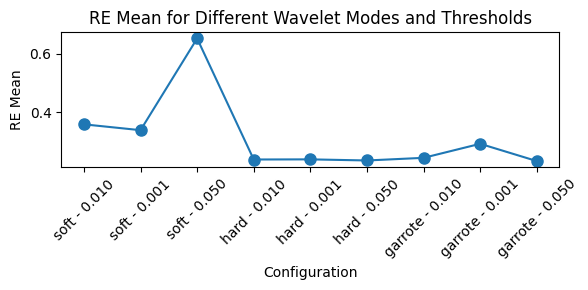

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


modes = ['soft', 'soft', 'soft', 'hard', 'hard', 'hard', 'garrote', 'garrote', 'garrote']
thresholds = [0.01, 0.001, 0.05, 0.01, 0.001, 0.05, 0.01, 0.001, 0.05]
re_means = [0.3590, 0.3391, 0.6515, 0.2392, 0.2397, 0.2359, 0.2449, 0.2927, 0.2339]


x_values = np.arange(len(modes))


fig, ax = plt.subplots(figsize=(6, 3))


ax.plot(x_values, re_means, marker='o', linestyle='-', markersize=8)


ax.set_xlabel('Configuration')
ax.set_ylabel('RE Mean')
ax.set_title('RE Mean for Different Wavelet Modes and Thresholds')


ax.set_xticks(x_values)
ax.set_xticklabels([f'{modes[i]} - {thresholds[i]:.3f}' for i in range(len(modes))], rotation=45)


plt.tight_layout()
plt.show()


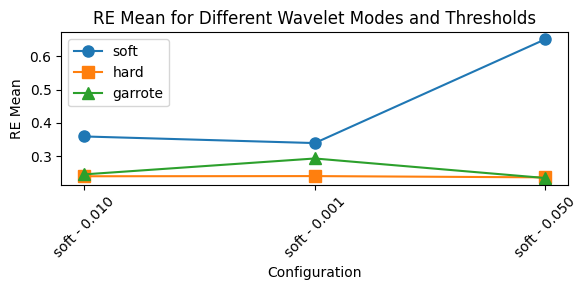

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


modes = ['soft', 'soft', 'soft', 'hard', 'hard', 'hard', 'garrote', 'garrote', 'garrote']
thresholds = [0.01, 0.001, 0.05, 0.01, 0.001, 0.05, 0.01, 0.001, 0.05]
re_means = [0.3590, 0.3391, 0.6515, 0.2392, 0.2397, 0.2359, 0.2449, 0.2927, 0.2339]


soft_data = [re_means[i] for i in range(len(modes)) if modes[i] == 'soft']
hard_data = [re_means[i] for i in range(len(modes)) if modes[i] == 'hard']
garrote_data = [re_means[i] for i in range(len(modes)) if modes[i] == 'garrote']


x_values = np.arange(len(soft_data))


fig, ax = plt.subplots(figsize=(6, 3))


ax.plot(x_values, soft_data, marker='o', linestyle='-', markersize=8, label='soft')
ax.plot(x_values, hard_data, marker='s', linestyle='-', markersize=8, label='hard')
ax.plot(x_values, garrote_data, marker='^', linestyle='-', markersize=8, label='garrote')


ax.set_xlabel('Configuration')
ax.set_ylabel('RE Mean')
ax.set_title('RE Mean for Different Wavelet Modes and Thresholds')

ax.set_xticks(x_values)
ax.set_xticklabels([f'{modes[i]} - {thresholds[i]:.3f}' for i in range(len(x_values))], rotation=45)


ax.legend()


plt.tight_layout()
plt.show()
